# EDA y ETL

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv(r'data\train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Umbral de nulos
threshold = 0.9

# Calcular % de nulos por columna
null_percentages = train.isnull().mean()

# Columnas a eliminar (más del threshold de nulos)
cols_to_drop = null_percentages[null_percentages > threshold].sort_values(ascending=False)

# Mostrar reporte
print("🔍 Columnas eliminadas por tener más del 90% de nulos:")
print(cols_to_drop.apply(lambda x: f"{x:.1%}"))

# Crear nuevo DataFrame sin esas columnas
train_reduced = train.drop(columns=cols_to_drop.index)

# Confirmación final
print(f"\n✅ Columnas originales: {train.shape[1]} | Columnas finales: {train_reduced.shape[1]}")


🔍 Columnas eliminadas por tener más del 90% de nulos:
PoolQC         99.5%
MiscFeature    96.3%
Alley          93.8%
dtype: object

✅ Columnas originales: 81 | Columnas finales: 78


In [5]:
# Rango intermedio de nulos: entre 40% y 90%
intermediate_nulls = null_percentages[(null_percentages > 0.4) & (null_percentages <= 0.9)].sort_values(ascending=False)

# Mostrar las columnas con nulos intermedios
print("🧐 Columnas con entre 40% y 90% de nulos:")
print(intermediate_nulls.apply(lambda x: f"{x:.1%}"))


🧐 Columnas con entre 40% y 90% de nulos:
Fence          80.8%
MasVnrType     59.7%
FireplaceQu    47.3%
dtype: object


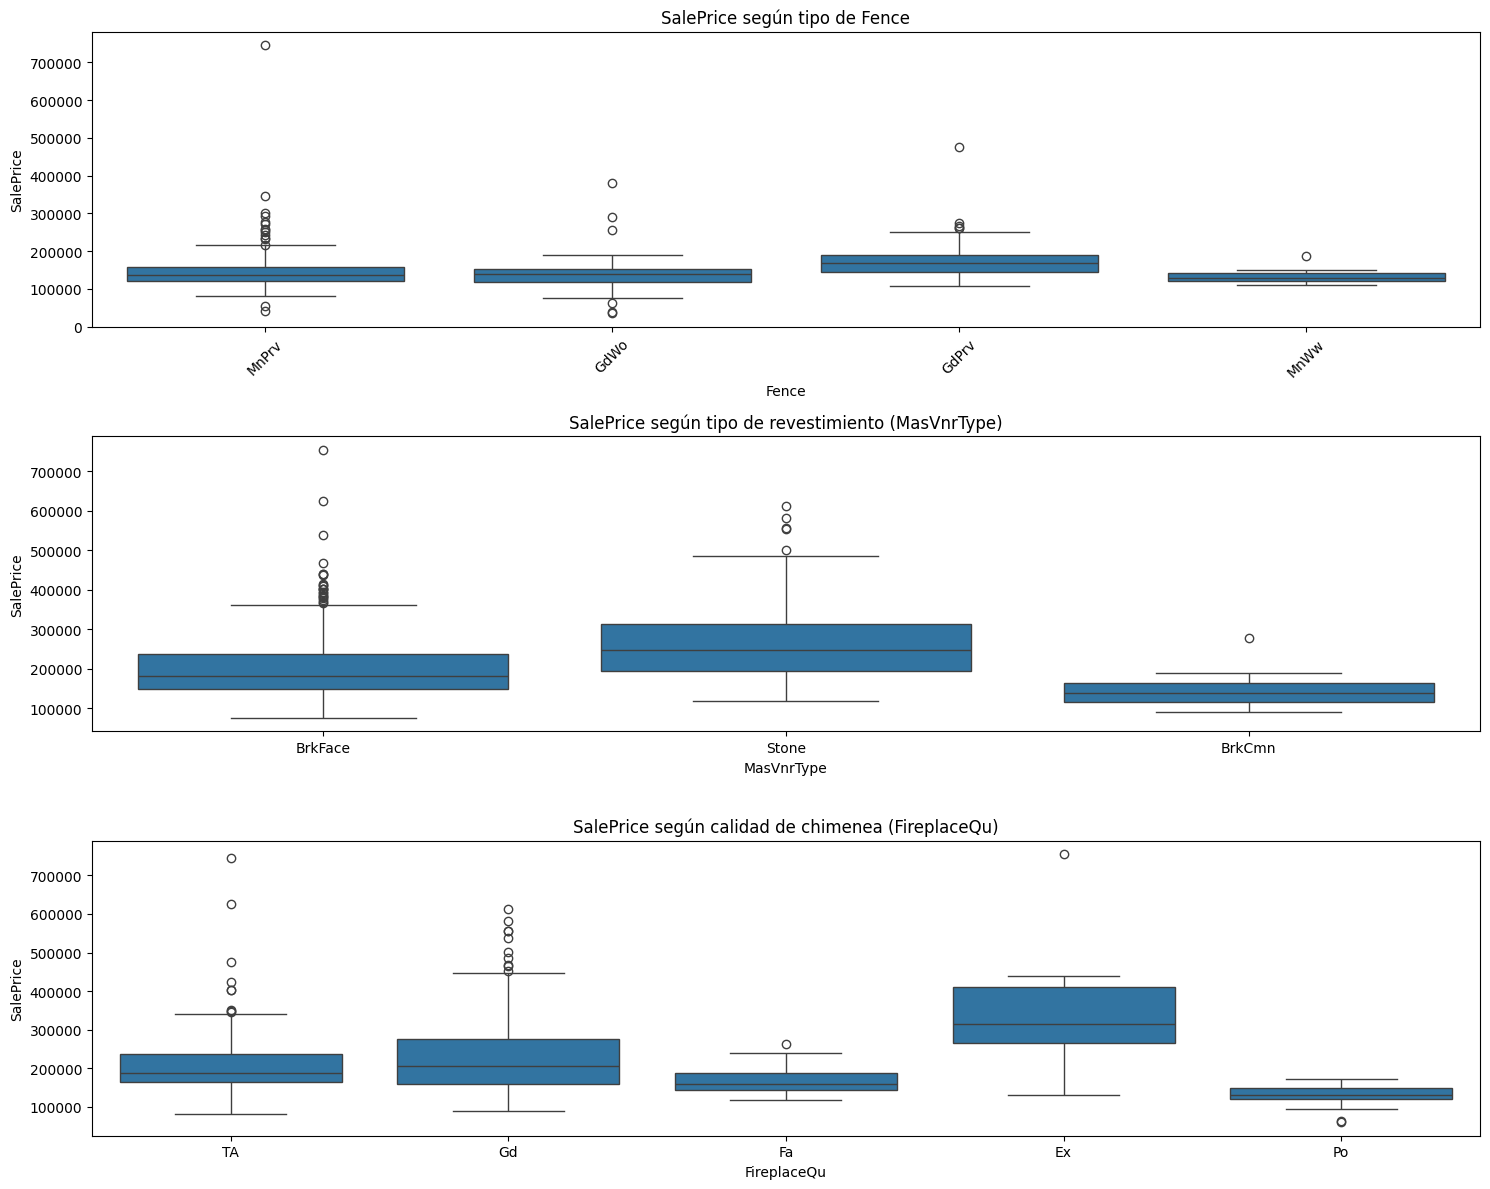

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aumentar el tamaño general del gráfico
plt.figure(figsize=(15, 12))

# Fence
plt.subplot(3, 1, 1)
sns.boxplot(x='Fence', y='SalePrice', data=train_reduced)
plt.title("SalePrice según tipo de Fence")
plt.xticks(rotation=45)

# MasVnrType
plt.subplot(3, 1, 2)
sns.boxplot(x='MasVnrType', y='SalePrice', data=train_reduced)
plt.title("SalePrice según tipo de revestimiento (MasVnrType)")

# FireplaceQu
plt.subplot(3, 1, 3)
sns.boxplot(x='FireplaceQu', y='SalePrice', data=train_reduced)
plt.title("SalePrice según calidad de chimenea (FireplaceQu)")

plt.tight_layout()
plt.show()


In [7]:
# Total de registros con 0 chimeneas
sin_chimenea = train_reduced[train_reduced['Fireplaces'] == 0]

# Cuántos de esos tienen calidad nula
nulos_correctos = sin_chimenea['FireplaceQu'].isnull().sum()

# Total de registros con calidad nula
total_nulos = train_reduced['FireplaceQu'].isnull().sum()

# Chequear si hay inconsistencias (casas con chimeneas pero sin calidad)
inconsistencias = train_reduced[(train_reduced['Fireplaces'] > 0) & (train_reduced['FireplaceQu'].isnull())]

# Reporte
print(f"Registros con Fireplaces == 0: {len(sin_chimenea)}")
print(f"De esos, tienen FireplaceQu nulo: {nulos_correctos}")
print(f"Total de FireplaceQu nulos en todo el dataset: {total_nulos}")
print(f"Inconsistencias (chimenea > 0 pero calidad nula): {len(inconsistencias)}")


Registros con Fireplaces == 0: 690
De esos, tienen FireplaceQu nulo: 690
Total de FireplaceQu nulos en todo el dataset: 690
Inconsistencias (chimenea > 0 pero calidad nula): 0


In [8]:
train_reduced['FireplaceQu'] = train_reduced['FireplaceQu'].fillna('None')

In [9]:
# Cuántos registros tienen MasVnrType nulo
nulos_tipo = train_reduced['MasVnrType'].isnull().sum()

# Cuántos de esos tienen MasVnrArea igual a 0
nulos_tipo_y_area_0 = train_reduced[(train_reduced['MasVnrType'].isnull()) & (train_reduced['MasVnrArea'] == 0)].shape[0]

# Ver si hay inconsistencias: tienen área > 0 pero el tipo es nulo
inconsistencias = train_reduced[(train_reduced['MasVnrType'].isnull()) & (train_reduced['MasVnrArea'] > 0)]

# Reporte
print(f"Registros con MasVnrType nulo: {nulos_tipo}")
print(f"De esos, tienen MasVnrArea == 0: {nulos_tipo_y_area_0}")
print(f"Inconsistencias (área > 0 pero tipo nulo): {len(inconsistencias)}")


Registros con MasVnrType nulo: 872
De esos, tienen MasVnrArea == 0: 859
Inconsistencias (área > 0 pero tipo nulo): 5


In [10]:
def imputar_masvnr_fireplace(df):
    df = df.copy()  # Para no modificar el original

    # 1. Imputar FireplaceQu como "None" si está vacío
    df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

    # 2. Imputar MasVnrType según MasVnrArea
    df['MasVnrType'] = df.apply(
        lambda row: 'None' if pd.isnull(row['MasVnrType']) and row['MasVnrArea'] == 0
        else 'Unknown' if pd.isnull(row['MasVnrType'])
        else row['MasVnrType'],
        axis=1
    )

    # 3. Imputar MasVnrArea como 0 si el tipo es 'None' o 'Unknown'
    df.loc[df['MasVnrType'].isin(['None', 'Unknown']) & (df['MasVnrArea'].isnull()), 'MasVnrArea'] = 0

    return df



In [11]:
train_reduced = imputar_masvnr_fireplace(train_reduced)

In [12]:
train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [13]:
train_reduced['MSSubClass'].value_counts()

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64

In [14]:
# Agrupamos por MSSubClass y calculamos cuántos tienen cerca
fence_by_class = train_reduced.groupby('MSSubClass')['Fence'].apply(lambda x: x.notnull().mean())

# Ordenar de mayor a menor para ver qué clases sí tienden a tener cerca
fence_by_class = fence_by_class.sort_values(ascending=False)

# Mostrar
print("Proporción de registros con 'Fence' presente por MSSubClass:")
print(fence_by_class.apply(lambda x: f"{x:.1%}"))


Proporción de registros con 'Fence' presente por MSSubClass:
MSSubClass
85     45.0%
80     44.8%
45     33.3%
75     31.2%
50     30.6%
70     23.3%
20     21.8%
30     21.7%
180    20.0%
190    13.3%
60     11.0%
90      5.8%
160     4.8%
120     2.3%
40      0.0%
Name: Fence, dtype: object


In [15]:
# Calcular proporción de registros con 'Fence' presente por BldgType
fence_by_bldgtype = train_reduced.groupby('BldgType')['Fence'].apply(lambda x: x.notnull().mean())

# Ordenar y mostrar
fence_by_bldgtype = fence_by_bldgtype.sort_values(ascending=False)
print("Proporción de registros con 'Fence' presente por BldgType:")
print(fence_by_bldgtype.apply(lambda x: f"{x:.1%}"))


Proporción de registros con 'Fence' presente por BldgType:
BldgType
1Fam      21.9%
2fmCon    12.9%
Twnhs      7.0%
Duplex     5.8%
TwnhsE     3.5%
Name: Fence, dtype: object


In [16]:
train_reduced.drop(columns='Fence', inplace=True)

In [17]:
train_reduced['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [18]:
medianas_por_zona = train_reduced.groupby('MSZoning')['LotFrontage'].median()
print("Mediana de LotFrontage por MSZoning:")
print(medianas_por_zona)


Mediana de LotFrontage por MSZoning:
MSZoning
C (all)    60.0
FV         65.0
RH         60.0
RL         72.0
RM         51.0
Name: LotFrontage, dtype: float64


In [19]:
corr = train_reduced[['LotFrontage', 'LotArea']].corr().iloc[0, 1]
print(f"Correlación entre LotFrontage y LotArea: {corr:.2f}")


Correlación entre LotFrontage y LotArea: 0.43


In [20]:
train_reduced['Neighborhood'].value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

In [21]:

train_reduced['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [22]:
lotfrontage_by_neigh = train_reduced.groupby('Neighborhood')['LotFrontage'].median().sort_values(ascending=False)

print("Mediana de LotFrontage por Neighborhood:")
print(lotfrontage_by_neigh)


Mediana de LotFrontage por Neighborhood:
Neighborhood
NoRidge    91.0
NridgHt    88.5
Timber     85.0
NWAmes     80.0
ClearCr    80.0
Crawfor    74.0
Somerst    73.5
NAmes      73.0
Mitchel    73.0
Sawyer     71.0
CollgCr    70.0
Veenker    68.0
SawyerW    66.5
Edwards    65.5
Gilbert    65.0
StoneBr    61.5
IDOTRR     60.0
OldTown    60.0
SWISU      60.0
BrkSide    52.0
Blmngtn    43.0
NPkVill    24.0
Blueste    24.0
BrDale     21.0
MeadowV    21.0
Name: LotFrontage, dtype: float64


In [23]:
# Crear nueva columna combinada
train_reduced['Zoning_Neighborhood'] = train_reduced['MSZoning'] + "_" + train_reduced['Neighborhood']

In [24]:
print("Cantidad de combinaciones únicas:", train_reduced['Zoning_Neighborhood'].nunique())
print(train_reduced['Zoning_Neighborhood'].value_counts())


Cantidad de combinaciones únicas: 42
Zoning_Neighborhood
RL_NAmes           223
RL_CollgCr         140
RM_OldTown          95
RL_Edwards          90
RL_Gilbert          79
RL_NridgHt          76
RL_NWAmes           73
RL_Sawyer           72
FV_Somerst          65
RL_SawyerW          54
RL_Crawfor          46
RL_Mitchel          44
RL_NoRidge          41
RL_Timber           38
RM_BrkSide          30
RM_IDOTRR           28
RL_BrkSide          28
RL_ClearCr          28
RL_StoneBr          25
RL_Somerst          21
RL_SWISU            20
RL_OldTown          17
RM_MeadowV          17
RM_BrDale           16
RL_Blmngtn          16
RL_Veenker          11
RM_CollgCr          10
C (all)_IDOTRR       9
RL_NPkVill           9
RM_Edwards           8
RH_SWISU             5
RM_Mitchel           5
RH_SawyerW           5
RM_Crawfor           3
RH_Edwards           2
RM_Sawyer            2
RM_Blueste           2
RH_NAmes             2
RH_Crawfor           2
C (all)_OldTown      1
RM_Blmngtn           1


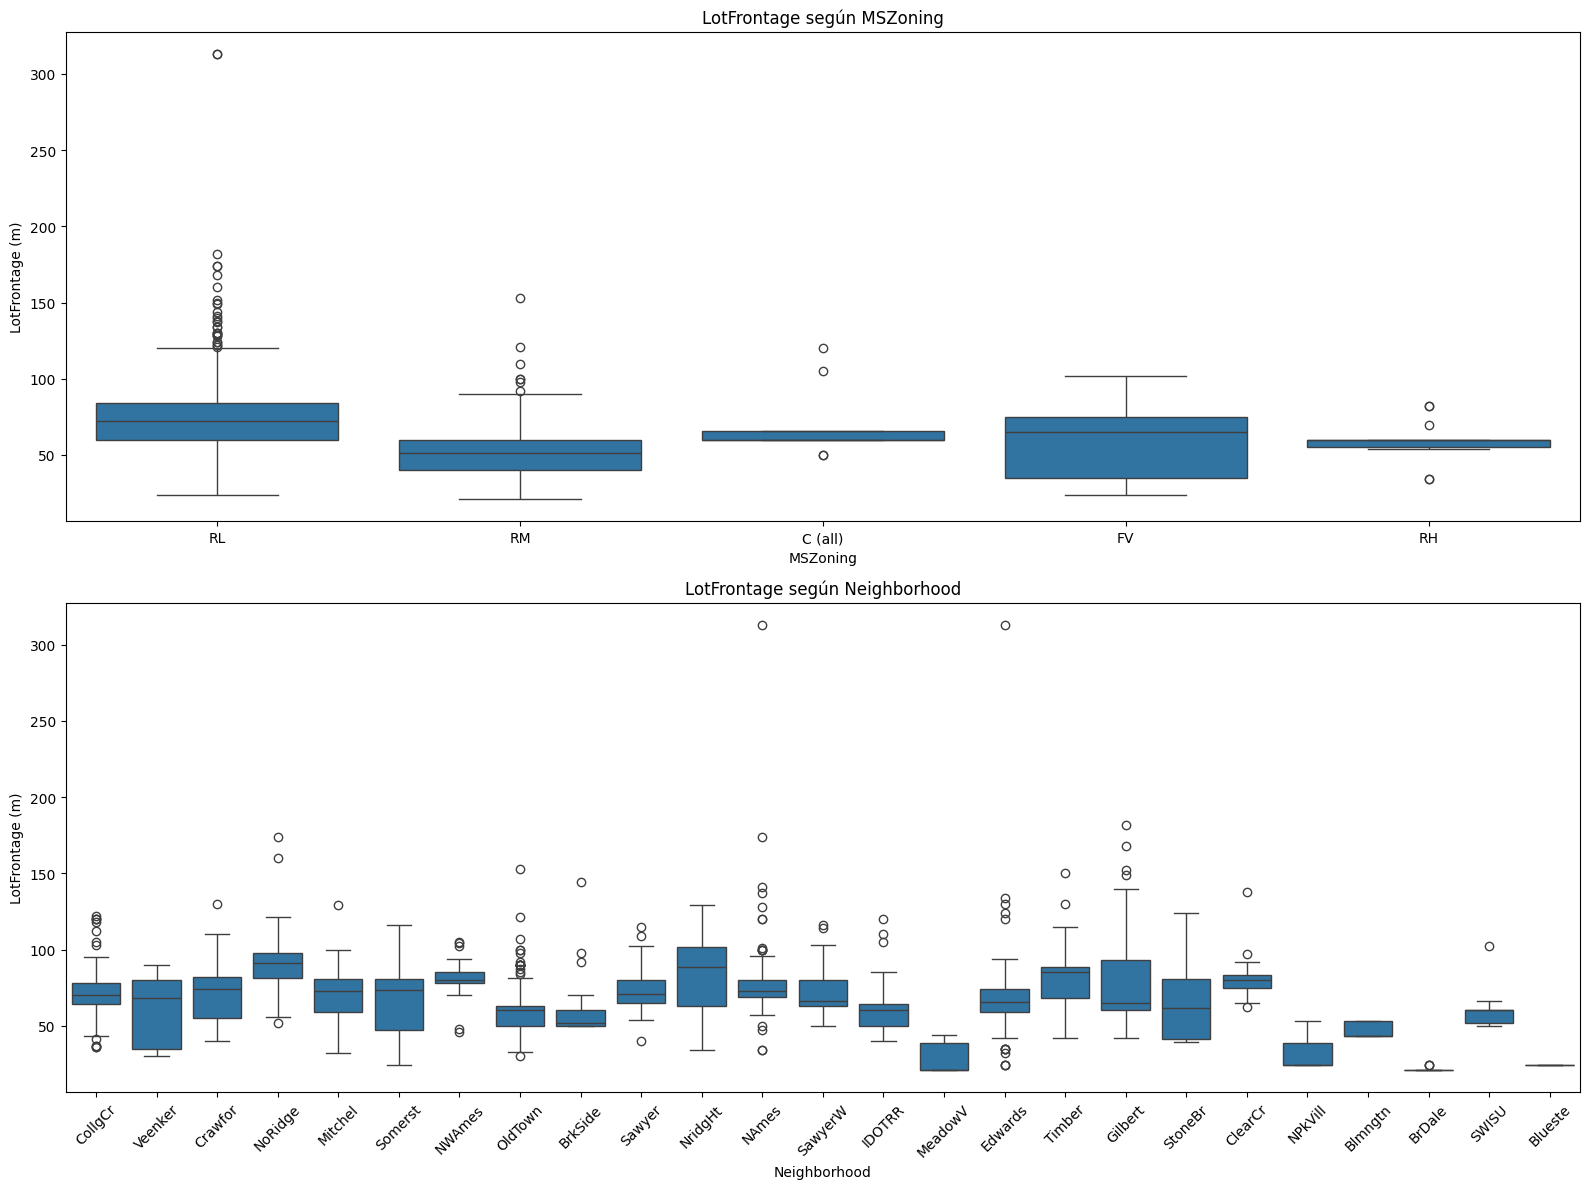

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

# LotFrontage vs MSZoning
plt.subplot(2, 1, 1)
sns.boxplot(x='MSZoning', y='LotFrontage', data=train_reduced)
plt.title("LotFrontage según MSZoning")
plt.ylabel("LotFrontage (m)")
plt.xlabel("MSZoning")

# LotFrontage vs Neighborhood
plt.subplot(2, 1, 2)
sns.boxplot(x='Neighborhood', y='LotFrontage', data=train_reduced)
plt.title("LotFrontage según Neighborhood")
plt.ylabel("LotFrontage (m)")
plt.xlabel("Neighborhood")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [26]:
def imputar_lotfrontage_por_barrio(df):
    df = df.copy()  # Para no modificar el original
    
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())
    )
    
    return df


In [27]:
train_reduced = imputar_lotfrontage_por_barrio(train_reduced)
print("Valores nulos restantes en LotFrontage:", train_reduced['LotFrontage'].isnull().sum())

Valores nulos restantes en LotFrontage: 0
